<a href="https://colab.research.google.com/github/shshojaei/research-of-super-resolution/blob/main/EDSR_my_mse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: https://keras.io/examples/vision/edsr/



In [ ]:
import os, shutil
from google.colab import drive
drive.mount('/content/drive')
!ls 'drive/MyDrive/Colab Notebooks/EDSR'

Mounted at /content/drive
my_mae	my_mse


## **Imports**

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.vgg19 import VGG19
from keras.models import Sequential

AUTOTUNE = tf.data.AUTOTUNE #for data augmentation

## **prepare dataset**

In [ ]:
# Download DIV2K from TF Datasets
# Using bicubic 4x degradation type
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()
    

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incomplete3RJ4SJ/div2k-train.tfrecord


  0%|          | 0/800 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incomplete3RJ4SJ/div2k-validation.tfrecord


  0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


## **image pre-processing**


*   batch size



In [ ]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    hight resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped

In [ ]:
def dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

In [ ]:
#visualize a few sample images

lowres, highres = next(iter(train_ds))

# Hight Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")

## **architecture** (method)


*   scale



In [ ]:
# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x

In [ ]:
# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x

In [ ]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

In [ ]:
model.summary()

Model: "edsr_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['rescaling[0][0]']              
                                64)                                                      

## **Training**


*   Optimizer
*   learning rate
*   loss function
*   epochs



In [ ]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optimizer_ = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)

In [ ]:
import keras.backend as K

def my_mae(y_true, y_pred):
  
  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)

  #convert Tensorflow tensor to numpy
  y_true = K.cast( y_true, 'float32')
  y_pred = K.cast( y_pred, 'float32')

  return K.mean(K.abs(y_pred - y_true), axis=-1)


In [ ]:
import keras.backend as K

def my_mse(y_true, y_pred):
  
  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)

  #convert Tensorflow tensor to numpy
  y_true = K.cast( y_true, 'float32')
  y_pred = K.cast( y_pred, 'float32')

  return K.mean(K.square(y_pred - y_true), axis=-1)

In [ ]:
def PSNR(super_resolution, high_resolution):
  #Compute the peak signal-to-noise ratio, measures quality of image.
  # Max value of pixel is 255
  psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
  return psnr_value

In [ ]:
#source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath = 'drive/MyDrive/Colab Notebooks/EDSR/my_mse/checkpoint'
STEPS_PER_EPOCH = 200

#Create a callback that saves the model's weights every 10 epochs 
#source: https://stackoverflow.com/questions/59069058/save-model-every-10-epochs-tensorflow-keras-v2

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    verbose=1,
    monitor='val_loss',
    mode='min',
    save_freq= int(10 * STEPS_PER_EPOCH)
)

In [ ]:
model.compile(optimizer=optimizer_ , loss=my_mse , metrics=[PSNR])

# Training for more epochs will improve results
history_my_mse = model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds, callbacks=[model_checkpoint_callback])

Epoch 1/100
200/200 [==============================] - 89s 335ms/step - loss: 4516.3833 - PSNR: 16.3457 - val_loss: 903.4492 - val_PSNR: 19.2189
Epoch 2/100
200/200 [==============================] - 7s 34ms/step - loss: 766.9464 - PSNR: 21.7696 - val_loss: 607.3629 - val_PSNR: 21.3272
Epoch 3/100
200/200 [==============================] - 7s 35ms/step - loss: 511.9940 - PSNR: 23.6836 - val_loss: 424.6982 - val_PSNR: 24.0442
Epoch 4/100
200/200 [==============================] - 7s 35ms/step - loss: 423.4343 - PSNR: 25.0844 - val_loss: 382.3544 - val_PSNR: 24.7764
Epoch 5/100
200/200 [==============================] - 8s 38ms/step - loss: 371.1095 - PSNR: 25.6620 - val_loss: 353.4440 - val_PSNR: 23.7719
Epoch 6/100
200/200 [==============================] - 7s 34ms/step - loss: 340.1866 - PSNR: 26.0540 - val_loss: 258.7904 - val_PSNR: 26.0467
Epoch 7/100
200/200 [==============================] - 7s 35ms/step - loss: 315.4760 - PSNR: 26.5334 - val_loss: 376.9582 - val_PSNR: 23.7450
Epo

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_mse/checkpoint/assets


200/200 [==============================] - 12s 62ms/step - loss: 274.4703 - PSNR: 28.0488 - val_loss: 270.8357 - val_PSNR: 26.7019
Epoch 11/100
200/200 [==============================] - 7s 35ms/step - loss: 271.9995 - PSNR: 28.0220 - val_loss: 291.9661 - val_PSNR: 26.9515
Epoch 12/100
200/200 [==============================] - 7s 35ms/step - loss: 253.8881 - PSNR: 27.6186 - val_loss: 236.6754 - val_PSNR: 26.3893
Epoch 13/100
200/200 [==============================] - 7s 35ms/step - loss: 245.8413 - PSNR: 28.4203 - val_loss: 271.0648 - val_PSNR: 29.3426
Epoch 14/100
200/200 [==============================] - 7s 35ms/step - loss: 253.8734 - PSNR: 28.1835 - val_loss: 219.0574 - val_PSNR: 28.5381
Epoch 15/100
200/200 [==============================] - 7s 35ms/step - loss: 243.4042 - PSNR: 28.6275 - val_loss: 217.0240 - val_PSNR: 28.4070
Epoch 16/100
200/200 [==============================] - 7s 35ms/step - loss: 246.8645 - PSNR: 28.2975 - val_loss: 232.1753 - val_PSNR: 30.7686
Epoch 17/10

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_mse/checkpoint/assets


200/200 [==============================] - 12s 60ms/step - loss: 232.6964 - PSNR: 29.7794 - val_loss: 181.6733 - val_PSNR: 30.7222
Epoch 21/100
200/200 [==============================] - 7s 36ms/step - loss: 230.6740 - PSNR: 30.0229 - val_loss: 152.2708 - val_PSNR: 28.9925
Epoch 22/100
200/200 [==============================] - 7s 35ms/step - loss: 215.6371 - PSNR: 30.0029 - val_loss: 184.2872 - val_PSNR: 29.8698
Epoch 23/100
200/200 [==============================] - 7s 35ms/step - loss: 212.0947 - PSNR: 30.1610 - val_loss: 255.2032 - val_PSNR: 28.7256
Epoch 24/100
200/200 [==============================] - 7s 35ms/step - loss: 225.9189 - PSNR: 29.5338 - val_loss: 193.5662 - val_PSNR: 29.2595
Epoch 25/100
200/200 [==============================] - 7s 35ms/step - loss: 219.9051 - PSNR: 29.9505 - val_loss: 226.7645 - val_PSNR: 29.0682
Epoch 26/100
200/200 [==============================] - 7s 35ms/step - loss: 218.4340 - PSNR: 30.8362 - val_loss: 175.1006 - val_PSNR: 28.1777
Epoch 27/10

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_mse/checkpoint/assets


200/200 [==============================] - 12s 59ms/step - loss: 197.4472 - PSNR: 30.7359 - val_loss: 210.9168 - val_PSNR: 31.5627
Epoch 31/100
200/200 [==============================] - 7s 36ms/step - loss: 211.4940 - PSNR: 30.4505 - val_loss: 199.8536 - val_PSNR: 28.4941
Epoch 32/100
200/200 [==============================] - 7s 36ms/step - loss: 212.3671 - PSNR: 30.3948 - val_loss: 169.1479 - val_PSNR: 29.8567
Epoch 33/100
200/200 [==============================] - 7s 35ms/step - loss: 212.8921 - PSNR: 30.0695 - val_loss: 169.5221 - val_PSNR: 32.3277
Epoch 34/100
200/200 [==============================] - 7s 36ms/step - loss: 205.4511 - PSNR: 31.3270 - val_loss: 181.4349 - val_PSNR: 31.3158
Epoch 35/100
200/200 [==============================] - 7s 36ms/step - loss: 213.9064 - PSNR: 30.5390 - val_loss: 210.6169 - val_PSNR: 29.3729
Epoch 36/100
200/200 [==============================] - 7s 36ms/step - loss: 206.5204 - PSNR: 30.1370 - val_loss: 240.3148 - val_PSNR: 27.5358
Epoch 37/10

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_mse/checkpoint/assets


200/200 [==============================] - 12s 60ms/step - loss: 203.8323 - PSNR: 31.1997 - val_loss: 200.6538 - val_PSNR: 28.3774
Epoch 41/100
200/200 [==============================] - 7s 36ms/step - loss: 200.2035 - PSNR: 30.6491 - val_loss: 176.7170 - val_PSNR: 33.5251
Epoch 42/100
200/200 [==============================] - 7s 36ms/step - loss: 216.5071 - PSNR: 31.3838 - val_loss: 165.2750 - val_PSNR: 31.8603
Epoch 43/100
200/200 [==============================] - 7s 36ms/step - loss: 206.3188 - PSNR: 31.1613 - val_loss: 189.1770 - val_PSNR: 33.0816
Epoch 44/100
200/200 [==============================] - 7s 36ms/step - loss: 201.0077 - PSNR: 30.9483 - val_loss: 162.4168 - val_PSNR: 32.0186
Epoch 45/100
200/200 [==============================] - 8s 38ms/step - loss: 199.8349 - PSNR: 31.3220 - val_loss: 192.5306 - val_PSNR: 31.1030
Epoch 46/100
200/200 [==============================] - 7s 36ms/step - loss: 198.6668 - PSNR: 30.8890 - val_loss: 196.1059 - val_PSNR: 29.0328
Epoch 47/10

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_mse/checkpoint/assets


200/200 [==============================] - 12s 60ms/step - loss: 202.3766 - PSNR: 31.7633 - val_loss: 169.1518 - val_PSNR: 32.2412
Epoch 51/100
200/200 [==============================] - 7s 36ms/step - loss: 201.4786 - PSNR: 31.3387 - val_loss: 182.5736 - val_PSNR: 28.1890
Epoch 52/100
200/200 [==============================] - 7s 35ms/step - loss: 204.6470 - PSNR: 31.4164 - val_loss: 161.2009 - val_PSNR: 33.9169
Epoch 53/100
200/200 [==============================] - 7s 35ms/step - loss: 205.0937 - PSNR: 30.4665 - val_loss: 190.8133 - val_PSNR: 27.6818
Epoch 54/100
200/200 [==============================] - 7s 36ms/step - loss: 203.1227 - PSNR: 31.1790 - val_loss: 208.3246 - val_PSNR: 27.6902
Epoch 55/100
200/200 [==============================] - 7s 36ms/step - loss: 193.9296 - PSNR: 31.7096 - val_loss: 188.2515 - val_PSNR: 29.7355
Epoch 56/100
200/200 [==============================] - 7s 36ms/step - loss: 191.7372 - PSNR: 31.1759 - val_loss: 197.2720 - val_PSNR: 30.4389
Epoch 57/10

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_mse/checkpoint/assets


200/200 [==============================] - 12s 59ms/step - loss: 196.5819 - PSNR: 31.0559 - val_loss: 190.8690 - val_PSNR: 26.9491
Epoch 61/100
200/200 [==============================] - 7s 35ms/step - loss: 193.1797 - PSNR: 31.0206 - val_loss: 208.6477 - val_PSNR: 27.4579
Epoch 62/100
200/200 [==============================] - 7s 35ms/step - loss: 197.3221 - PSNR: 31.6619 - val_loss: 192.4779 - val_PSNR: 35.1055
Epoch 63/100
200/200 [==============================] - 7s 36ms/step - loss: 188.0648 - PSNR: 31.6176 - val_loss: 248.4061 - val_PSNR: 28.8315
Epoch 64/100
200/200 [==============================] - 7s 36ms/step - loss: 198.0078 - PSNR: 32.1330 - val_loss: 191.8818 - val_PSNR: 31.3006
Epoch 65/100
200/200 [==============================] - 7s 36ms/step - loss: 202.1714 - PSNR: 32.4595 - val_loss: 167.1761 - val_PSNR: 33.8247
Epoch 66/100
200/200 [==============================] - 7s 36ms/step - loss: 192.3212 - PSNR: 32.0982 - val_loss: 194.6541 - val_PSNR: 31.0657
Epoch 67/10

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_mse/checkpoint/assets


200/200 [==============================] - 12s 59ms/step - loss: 190.0606 - PSNR: 31.5382 - val_loss: 212.9020 - val_PSNR: 30.6224
Epoch 71/100
200/200 [==============================] - 7s 36ms/step - loss: 187.0471 - PSNR: 31.5730 - val_loss: 175.7090 - val_PSNR: 30.4682
Epoch 72/100
200/200 [==============================] - 7s 36ms/step - loss: 193.0755 - PSNR: 31.6213 - val_loss: 197.8383 - val_PSNR: 28.4449
Epoch 73/100
200/200 [==============================] - 7s 35ms/step - loss: 194.4726 - PSNR: 31.3601 - val_loss: 171.2882 - val_PSNR: 32.2077
Epoch 74/100
200/200 [==============================] - 7s 36ms/step - loss: 195.0069 - PSNR: 31.5740 - val_loss: 199.8718 - val_PSNR: 29.9825
Epoch 75/100
200/200 [==============================] - 7s 36ms/step - loss: 193.3901 - PSNR: 31.6710 - val_loss: 181.0706 - val_PSNR: 33.7497
Epoch 76/100
200/200 [==============================] - 7s 36ms/step - loss: 194.3807 - PSNR: 31.1006 - val_loss: 180.7041 - val_PSNR: 29.6335
Epoch 77/10

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_mse/checkpoint/assets


200/200 [==============================] - 12s 59ms/step - loss: 197.6243 - PSNR: 31.9105 - val_loss: 141.3929 - val_PSNR: 32.6906
Epoch 81/100
200/200 [==============================] - 7s 35ms/step - loss: 184.7788 - PSNR: 31.5364 - val_loss: 203.2280 - val_PSNR: 31.7939
Epoch 82/100
200/200 [==============================] - 7s 36ms/step - loss: 189.1509 - PSNR: 32.3408 - val_loss: 196.8105 - val_PSNR: 31.6589
Epoch 83/100
200/200 [==============================] - 7s 36ms/step - loss: 183.8460 - PSNR: 32.2665 - val_loss: 182.3508 - val_PSNR: 27.8697
Epoch 84/100
200/200 [==============================] - 7s 36ms/step - loss: 188.8261 - PSNR: 31.9567 - val_loss: 165.5429 - val_PSNR: 27.5778
Epoch 85/100
200/200 [==============================] - 7s 36ms/step - loss: 185.8244 - PSNR: 32.3378 - val_loss: 195.7173 - val_PSNR: 31.2883
Epoch 86/100
200/200 [==============================] - 7s 36ms/step - loss: 192.2321 - PSNR: 31.9055 - val_loss: 202.9148 - val_PSNR: 29.0144
Epoch 87/10

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_mse/checkpoint/assets


200/200 [==============================] - 12s 59ms/step - loss: 189.2993 - PSNR: 31.6142 - val_loss: 205.7397 - val_PSNR: 26.4330
Epoch 91/100
200/200 [==============================] - 7s 35ms/step - loss: 193.6903 - PSNR: 31.5503 - val_loss: 189.4085 - val_PSNR: 31.6390
Epoch 92/100
200/200 [==============================] - 7s 36ms/step - loss: 188.5552 - PSNR: 32.2585 - val_loss: 154.5234 - val_PSNR: 29.3004
Epoch 93/100
200/200 [==============================] - 7s 35ms/step - loss: 194.6461 - PSNR: 31.4707 - val_loss: 183.3357 - val_PSNR: 35.9945
Epoch 94/100
200/200 [==============================] - 7s 36ms/step - loss: 192.7389 - PSNR: 32.3951 - val_loss: 175.1637 - val_PSNR: 29.7845
Epoch 95/100
200/200 [==============================] - 7s 36ms/step - loss: 186.2083 - PSNR: 31.8509 - val_loss: 155.4744 - val_PSNR: 30.8587
Epoch 96/100
200/200 [==============================] - 7s 35ms/step - loss: 188.9543 - PSNR: 32.0375 - val_loss: 203.2326 - val_PSNR: 28.5077
Epoch 97/10

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_mse/checkpoint/assets


200/200 [==============================] - 12s 59ms/step - loss: 180.9758 - PSNR: 32.4900 - val_loss: 153.4332 - val_PSNR: 37.6375


In [ ]:
#to continue training from last epoch that saved ?????
#model.load_weights(checkpoint_filepath)

In [ ]:
model.save('drive/MyDrive/Colab Notebooks/EDSR/my_mse/model_my_mse.hdf5')

In [ ]:
#model = tf.keras.models.load_model('drive/My Drive/Colab Notebooks/EDSR/model_my_mse.hdf5')

## **plots**

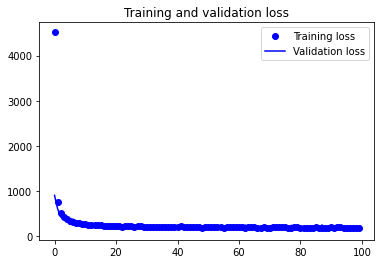

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history_my_mse.history['loss']
PSNR = history_my_mse.history['PSNR']
val_loss = history_my_mse.history['val_loss']
val_PSNR = history_my_mse.history['val_PSNR']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.show()